# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Extrapolating-behavior" data-toc-modified-id="Extrapolating-behavior-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Extrapolating behavior</a></div>

In [1]:
using GaussianProcesses

In [2]:
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
plt.rc("savefig", dpi=300.0)
# plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
se = SEIso(0.3, 0.3)

Type: GaussianProcesses.SEIso, Params: [0.3,0.3]


In [49]:
prior_GP = GP(;k=se, m=MeanZero(), logNoise=1e-8)

GP object:
  Dim = 0
  Number of observations = 0
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.274291,0.0865415]


  No observation data


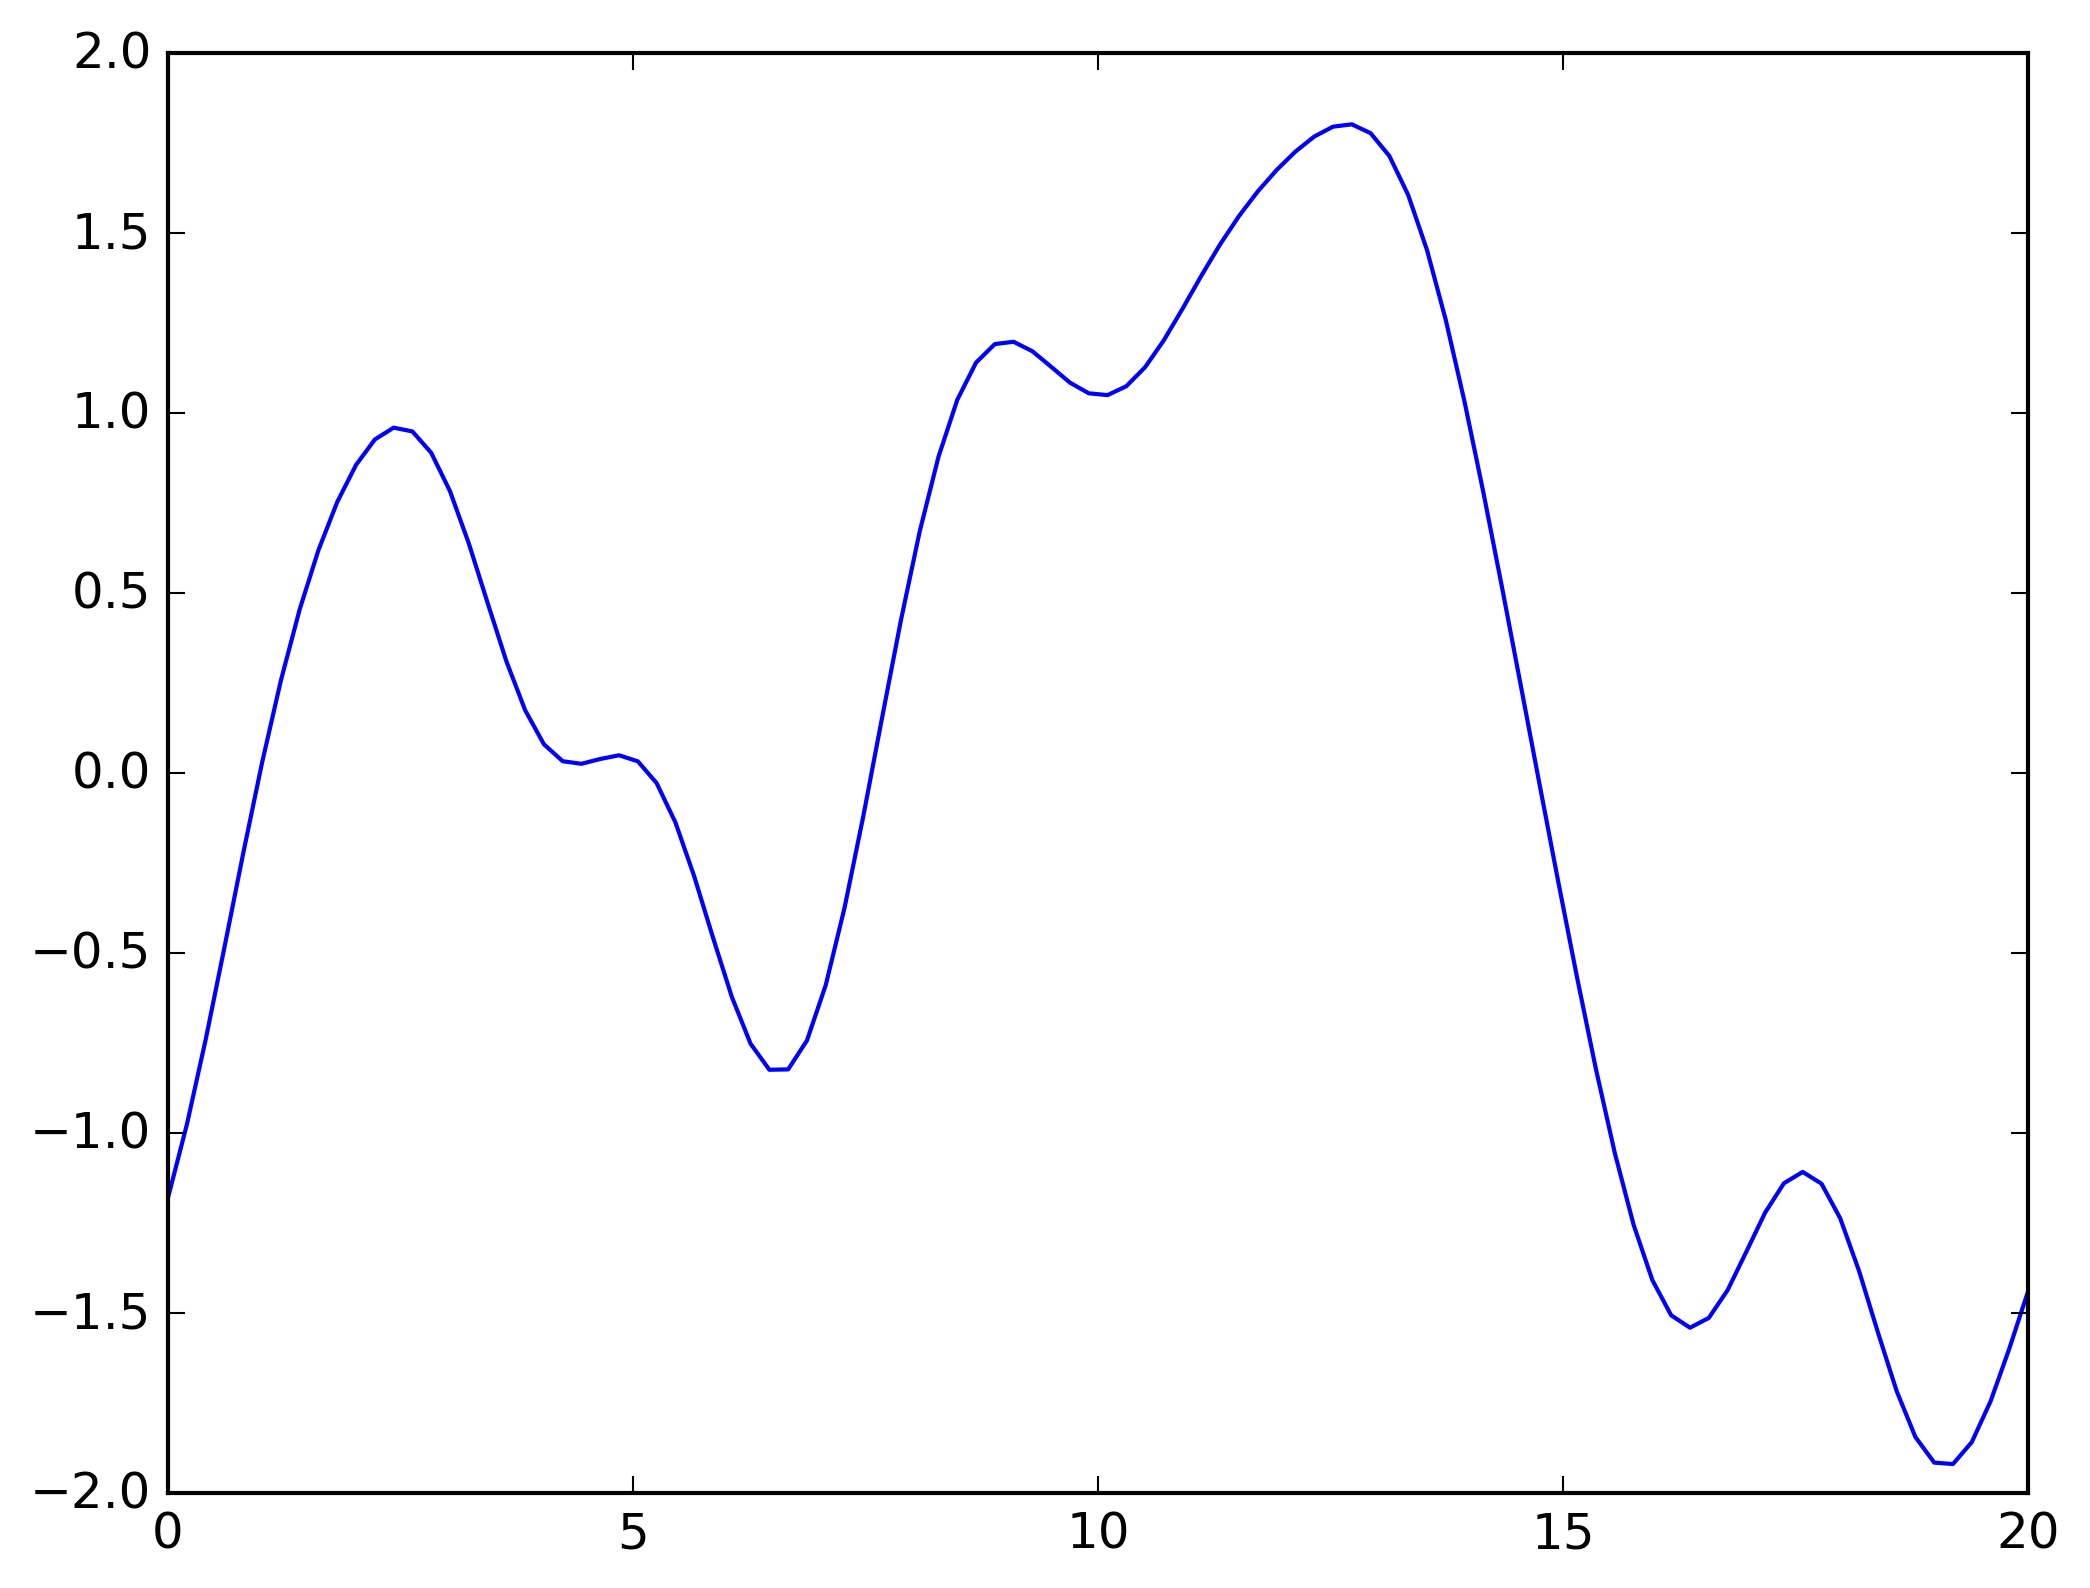

In [48]:
xx = linspace(0,20,100)
r=rand(prior_GP, xx, 1)
plt.plot(xx, r)
;

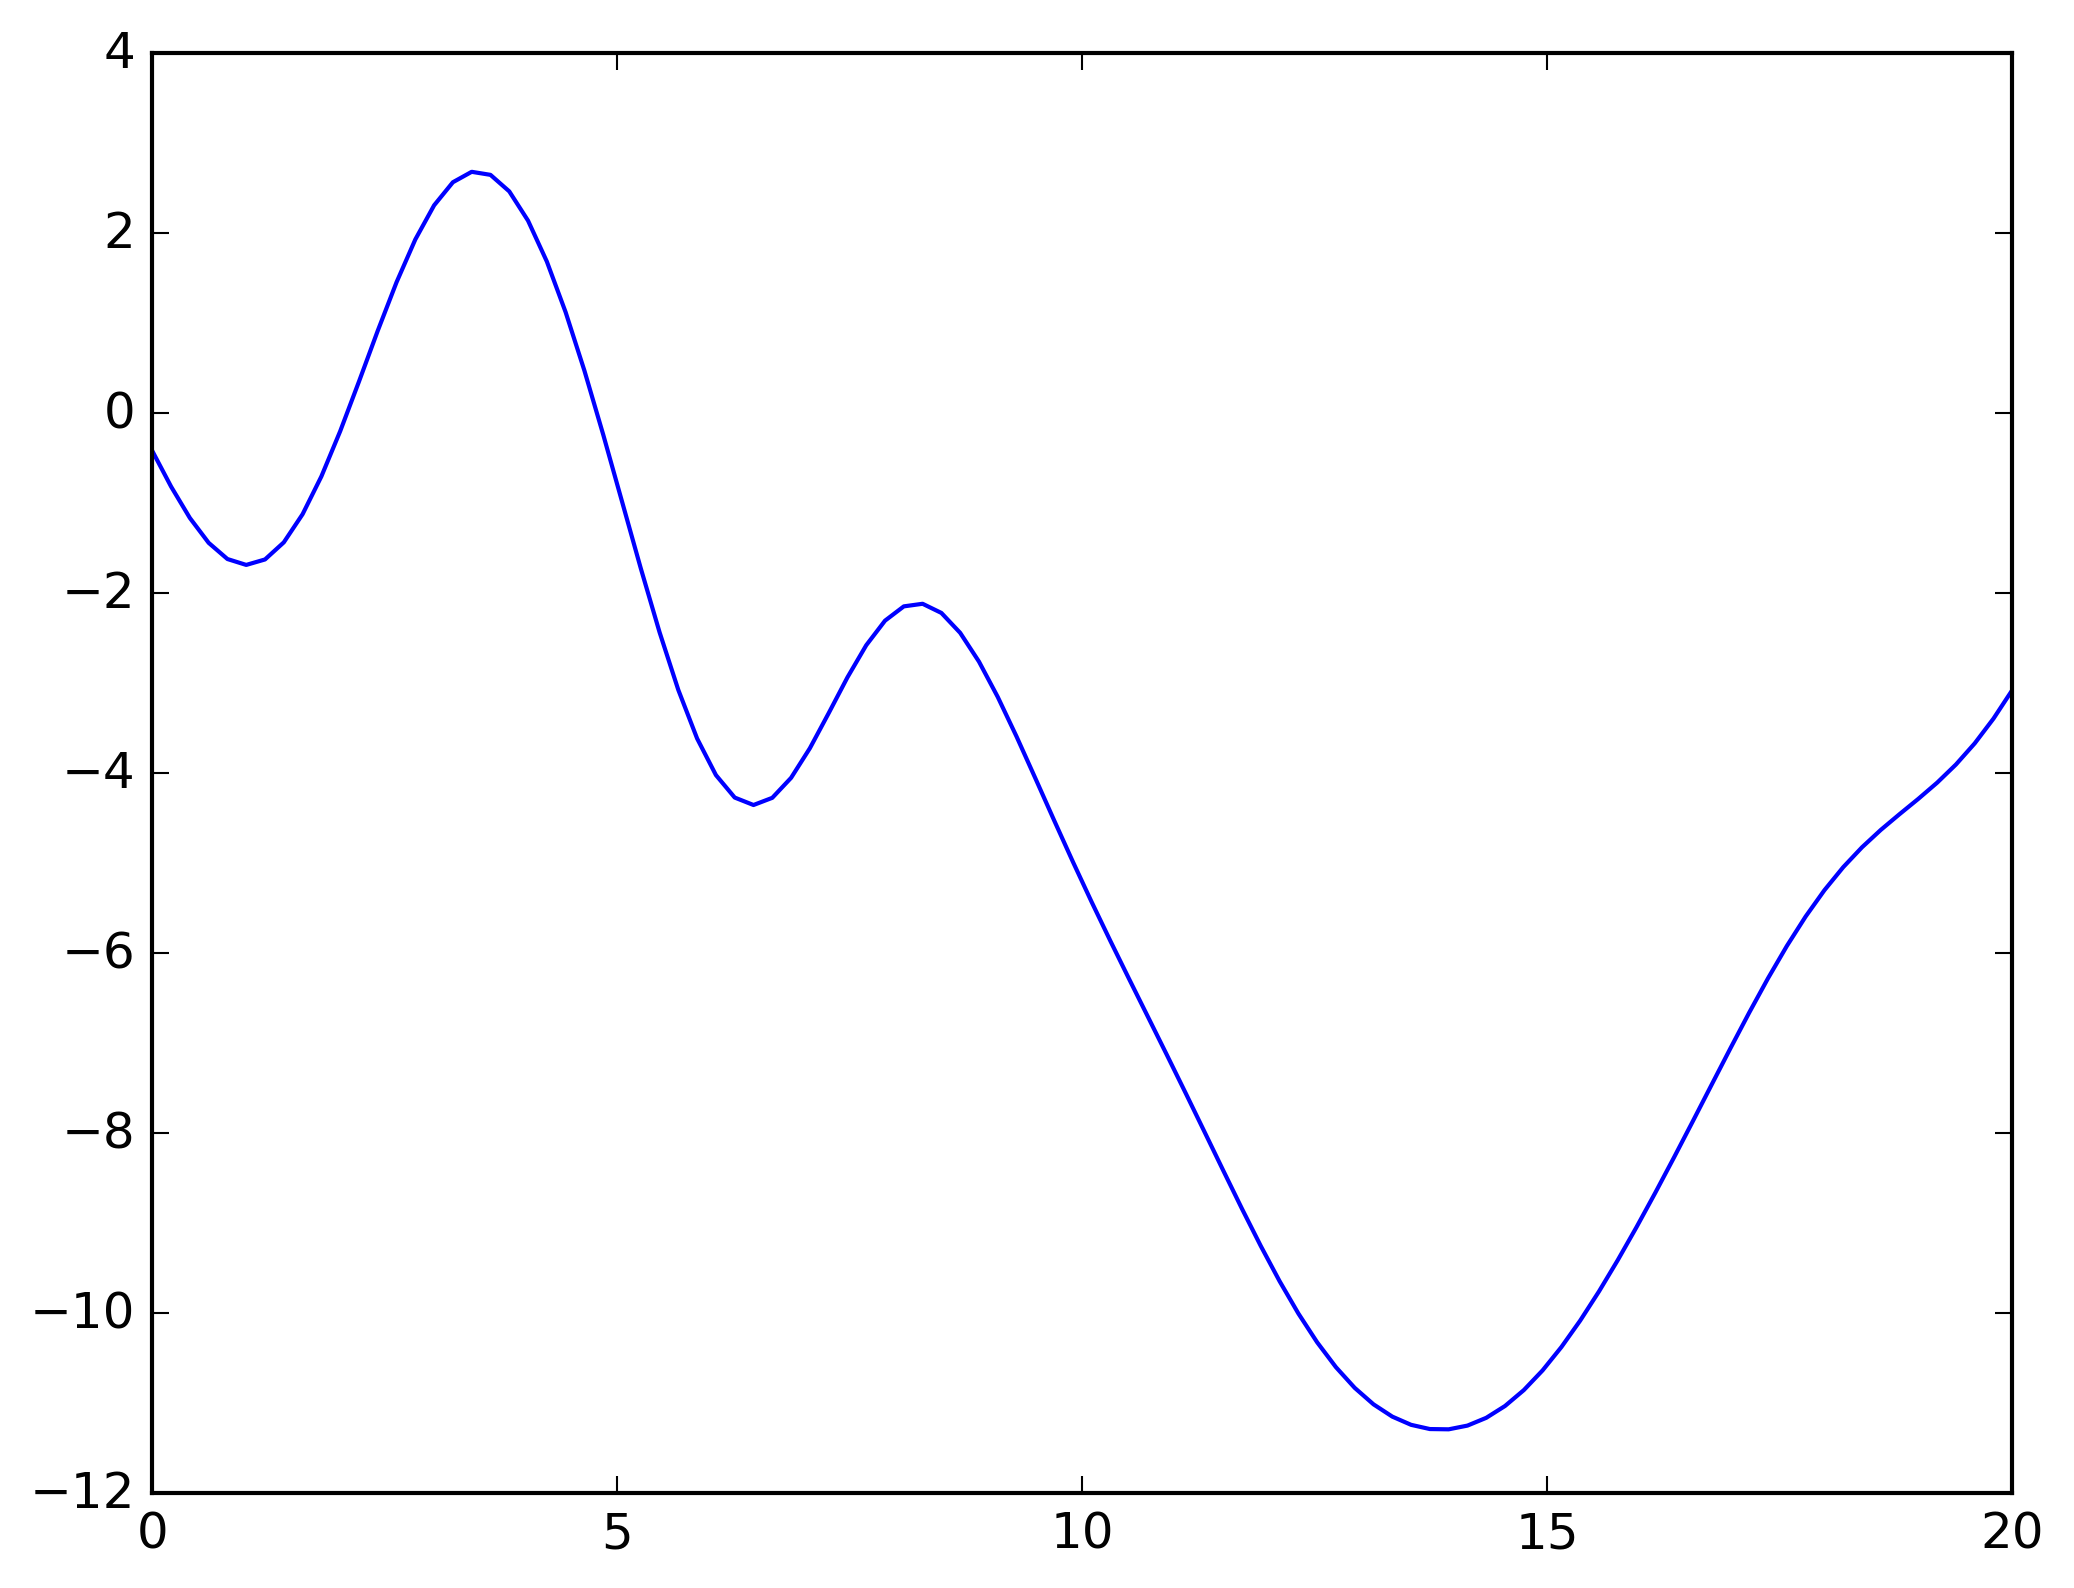

In [6]:
dx=median(diff(xx))
int_r = cumsum(r)*dx
plt.plot(xx, int_r)
;

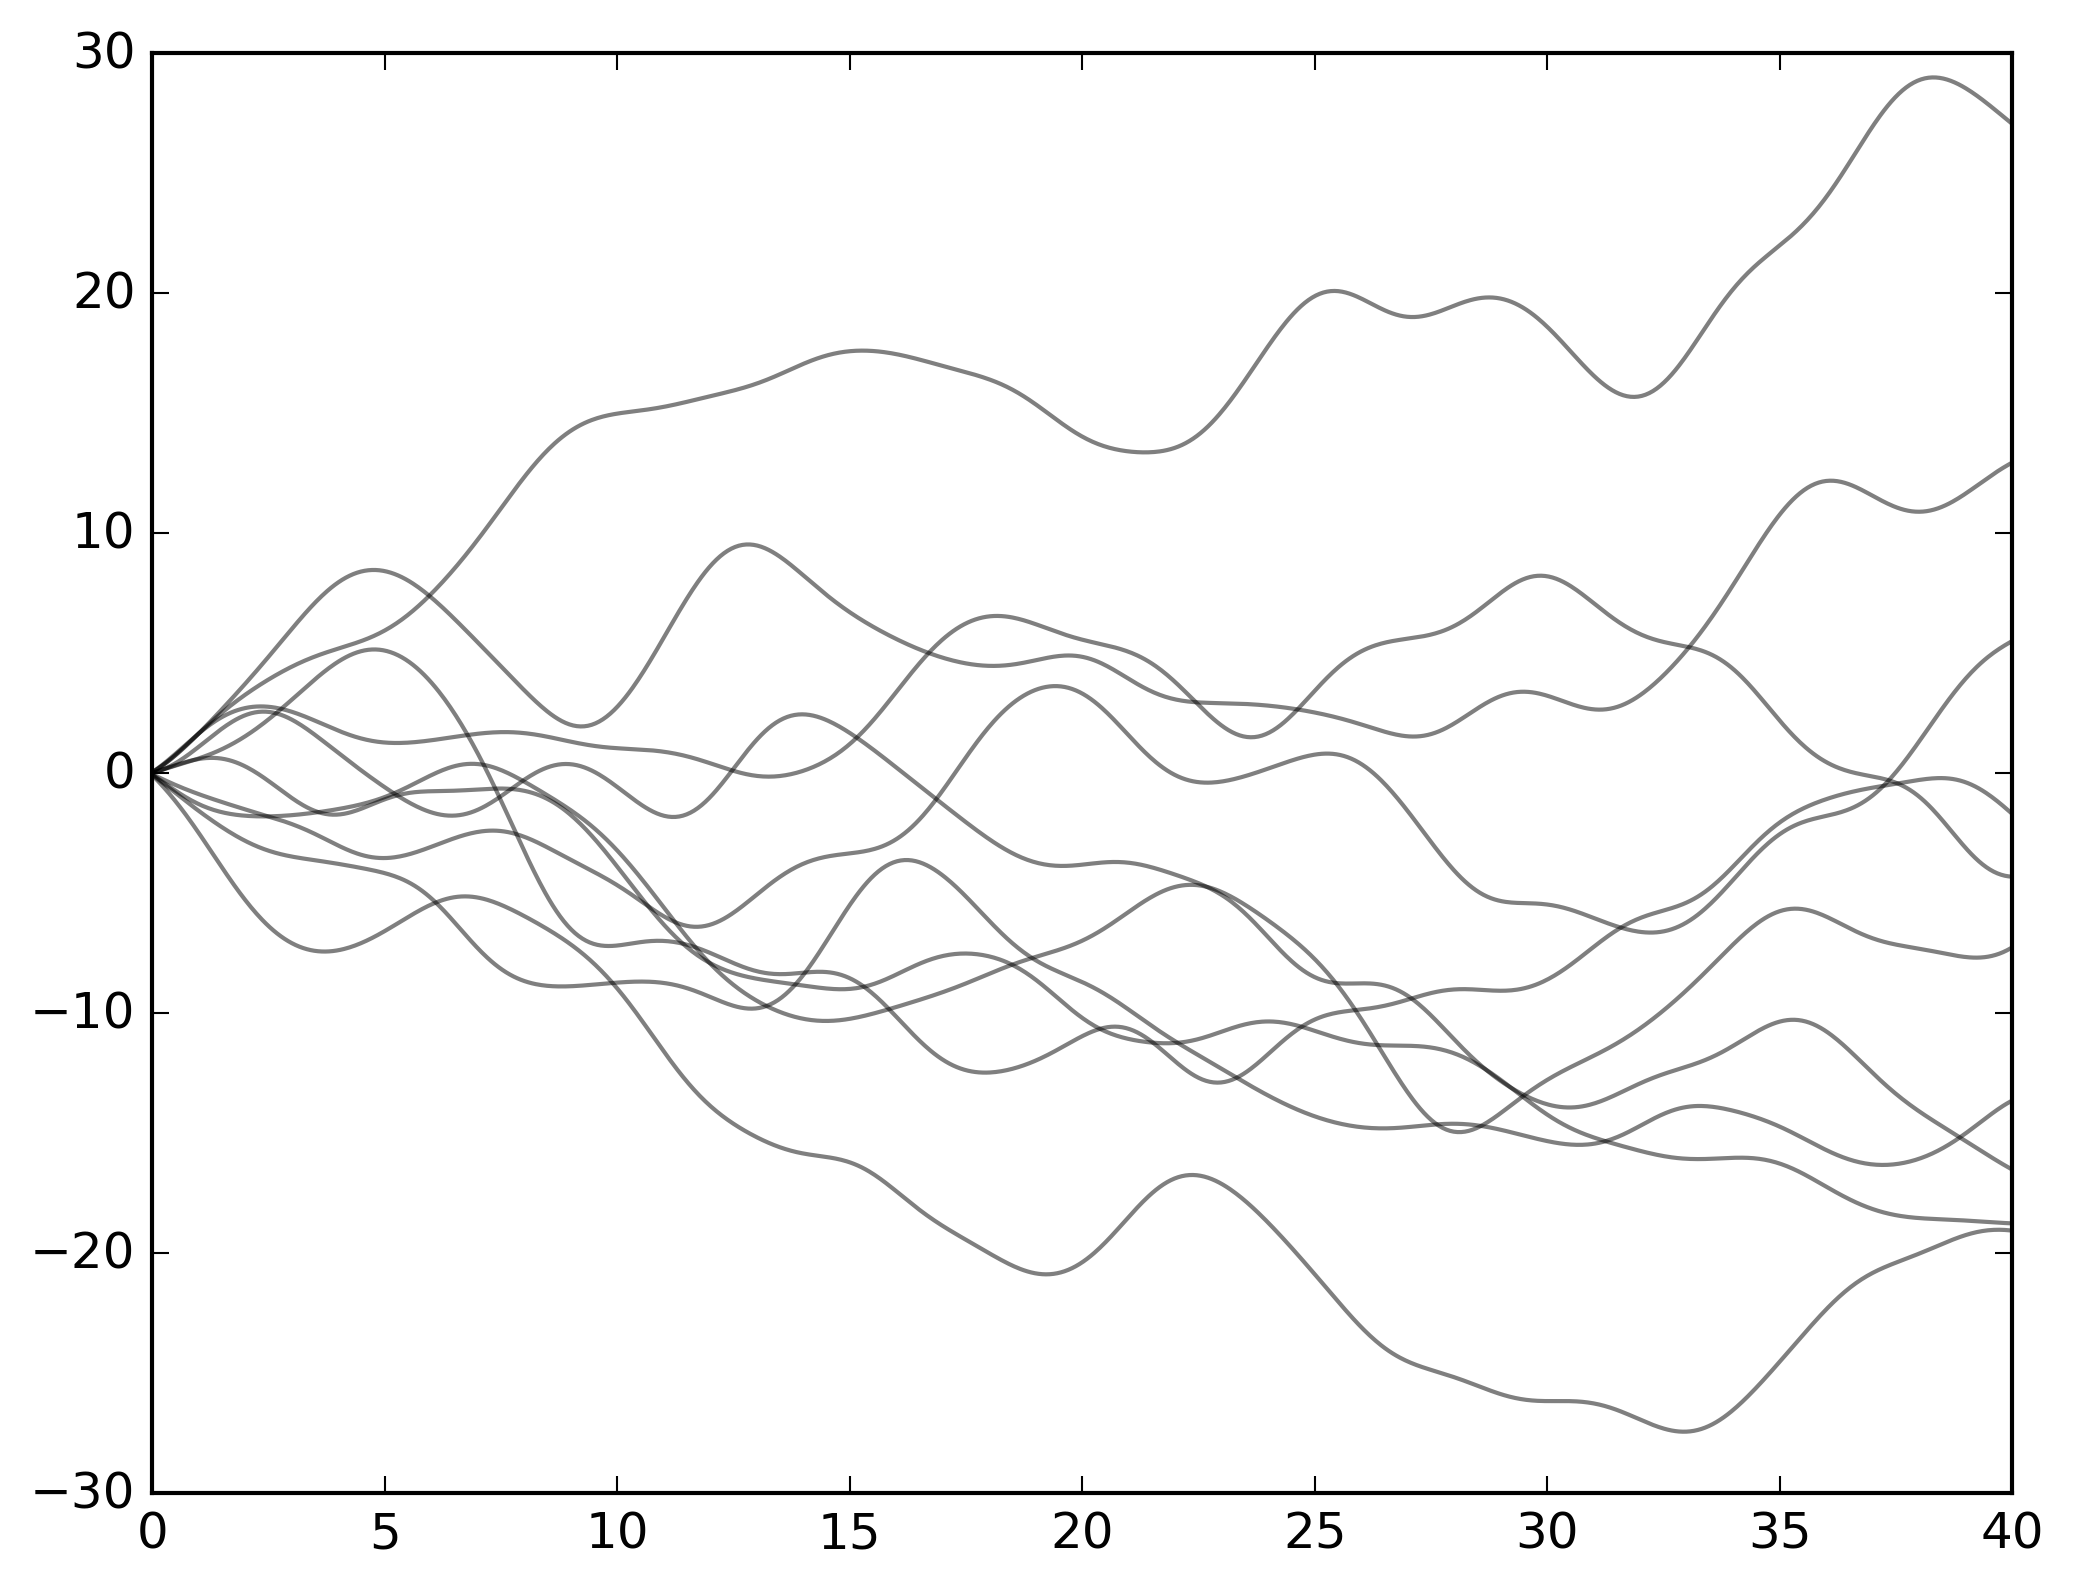

In [7]:
xx = linspace(0,40,1000)
for _ in 1:10
    r=rand(prior_GP, xx, 1)
    dx=median(diff(xx))
    int_r = cumsum(r)*dx
    plt.plot(xx, int_r, color="black", alpha=0.5)
end

In [8]:
function var_intgp(x, σ, l)
    u = x / l / √2
    2 * σ^2 * l^2 * ( u * √π  * erf(u) + exp(-u^2) - 1.0)
end

var_intgp (generic function with 1 method)

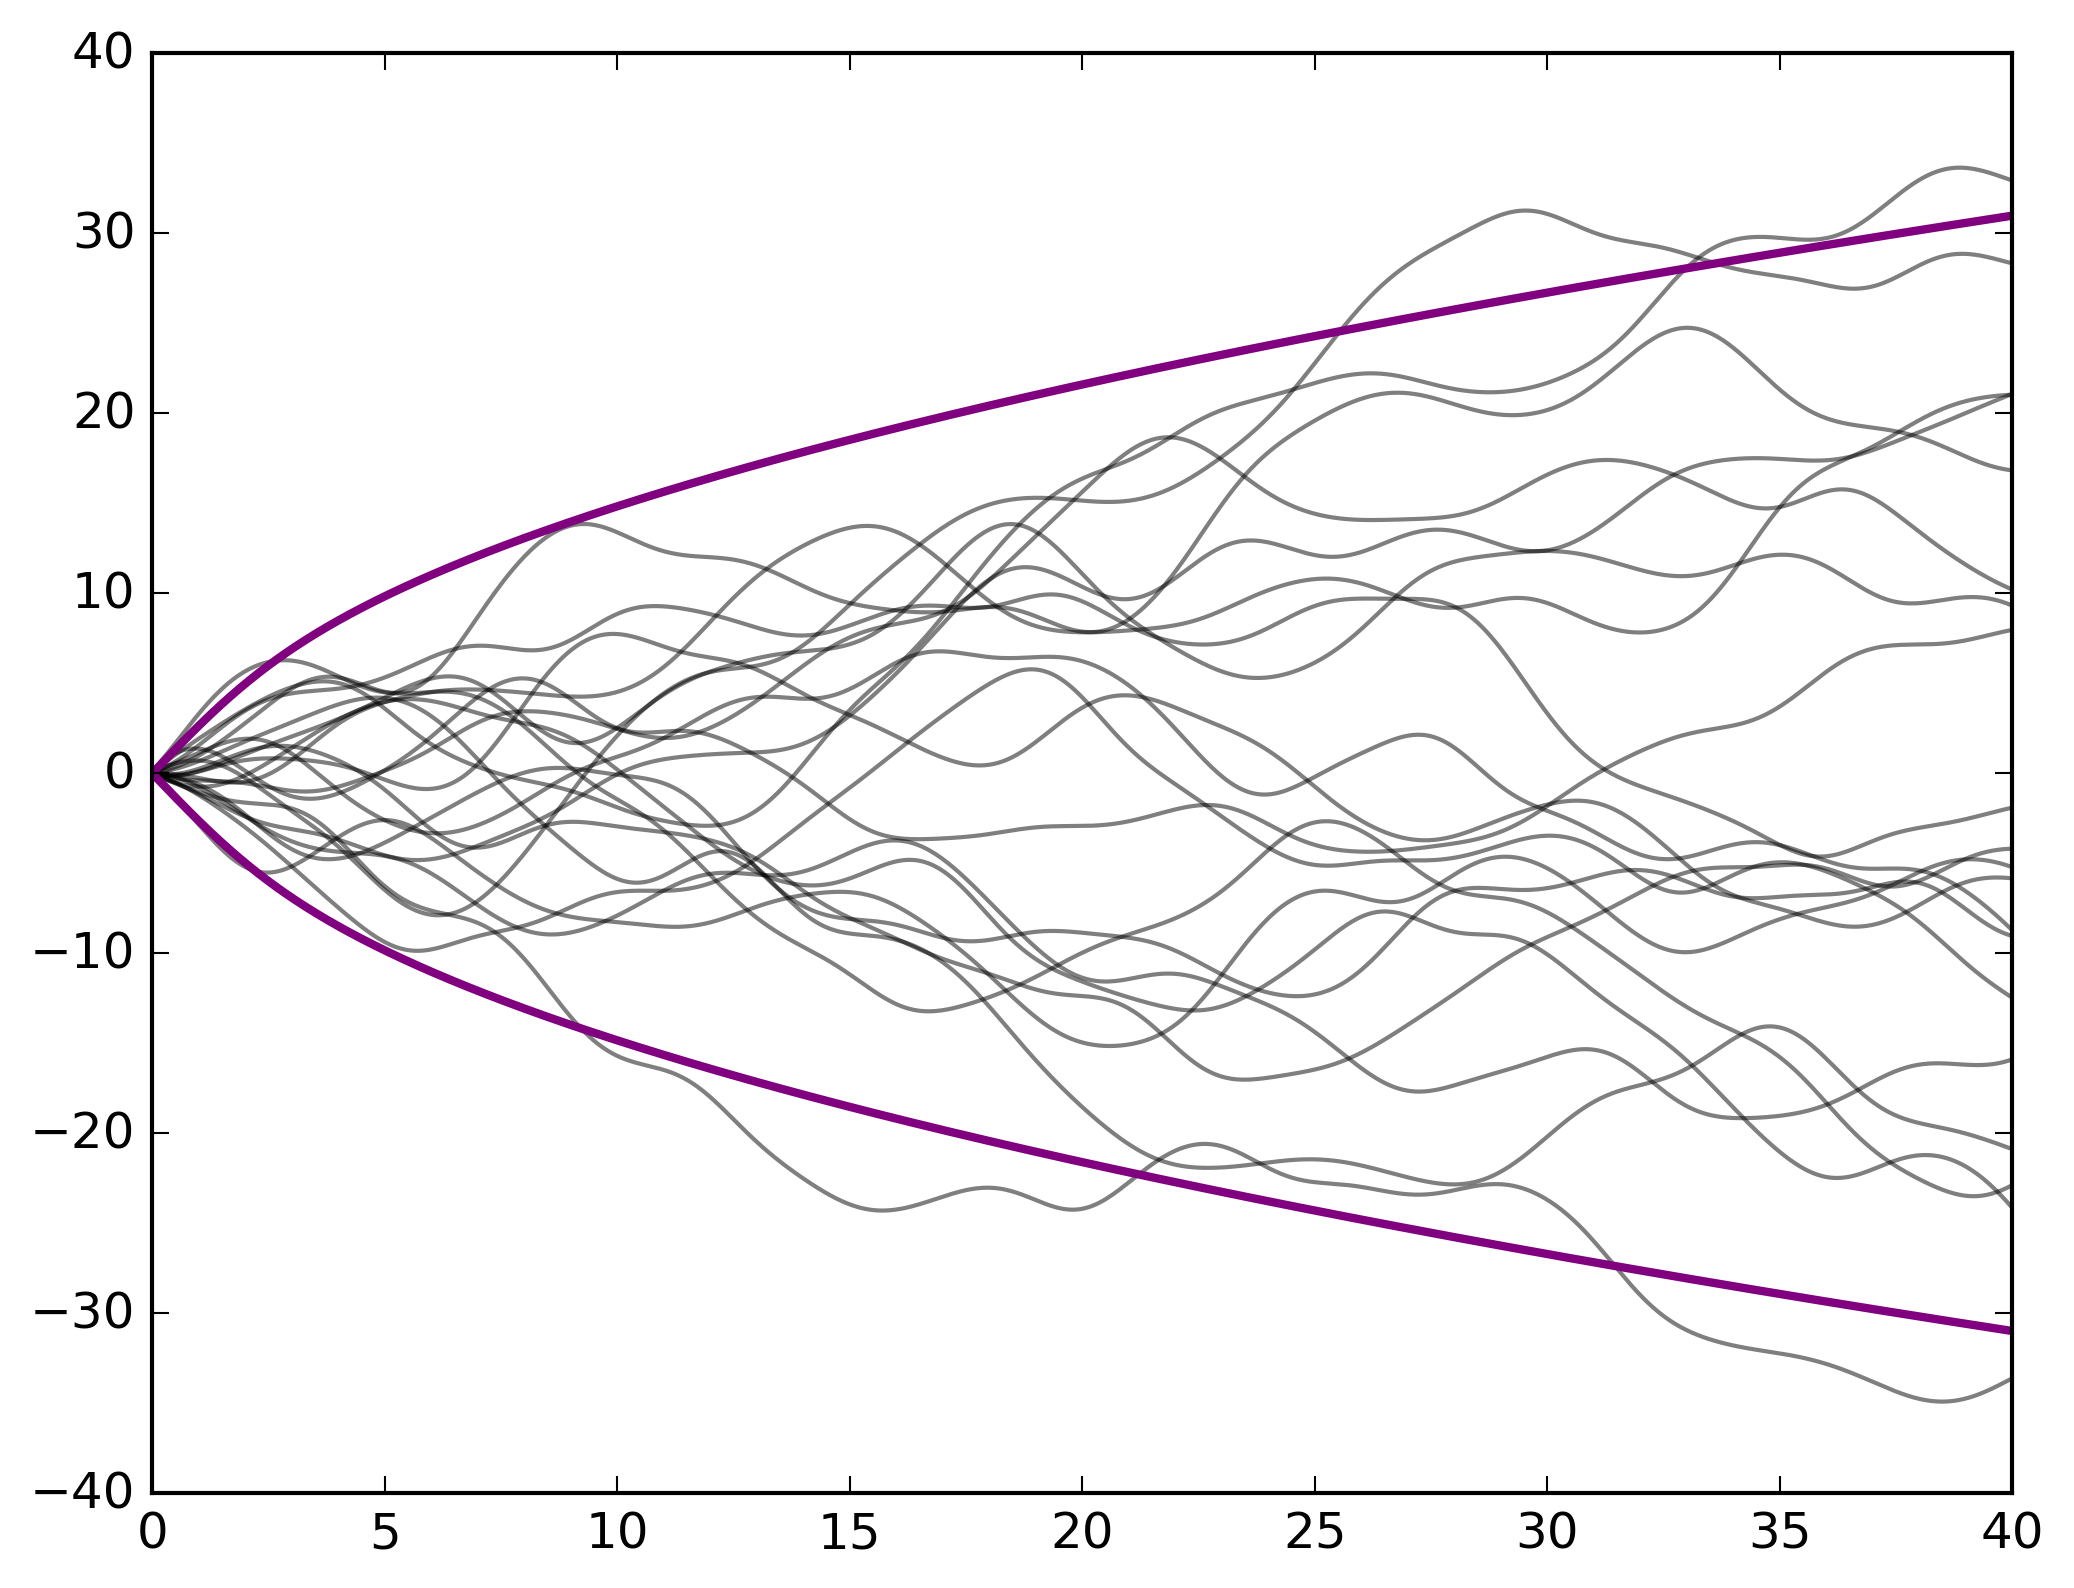

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31cd6d610>

In [9]:
xx = linspace(0,40,1000)
for _ in 1:20
    r=rand(prior_GP, xx, 1)
    dx=median(diff(xx))
    int_r = cumsum(r)*dx
    plt.plot(xx, int_r, color="black", alpha=0.5)
end
plt.plot(xx,  2*√(var_intgp.(xx, √se.σ2, √se.ℓ2)), linewidth=2, color="purple")
plt.plot(xx, -2*√(var_intgp.(xx, √se.σ2, √se.ℓ2)), linewidth=2, color="purple")

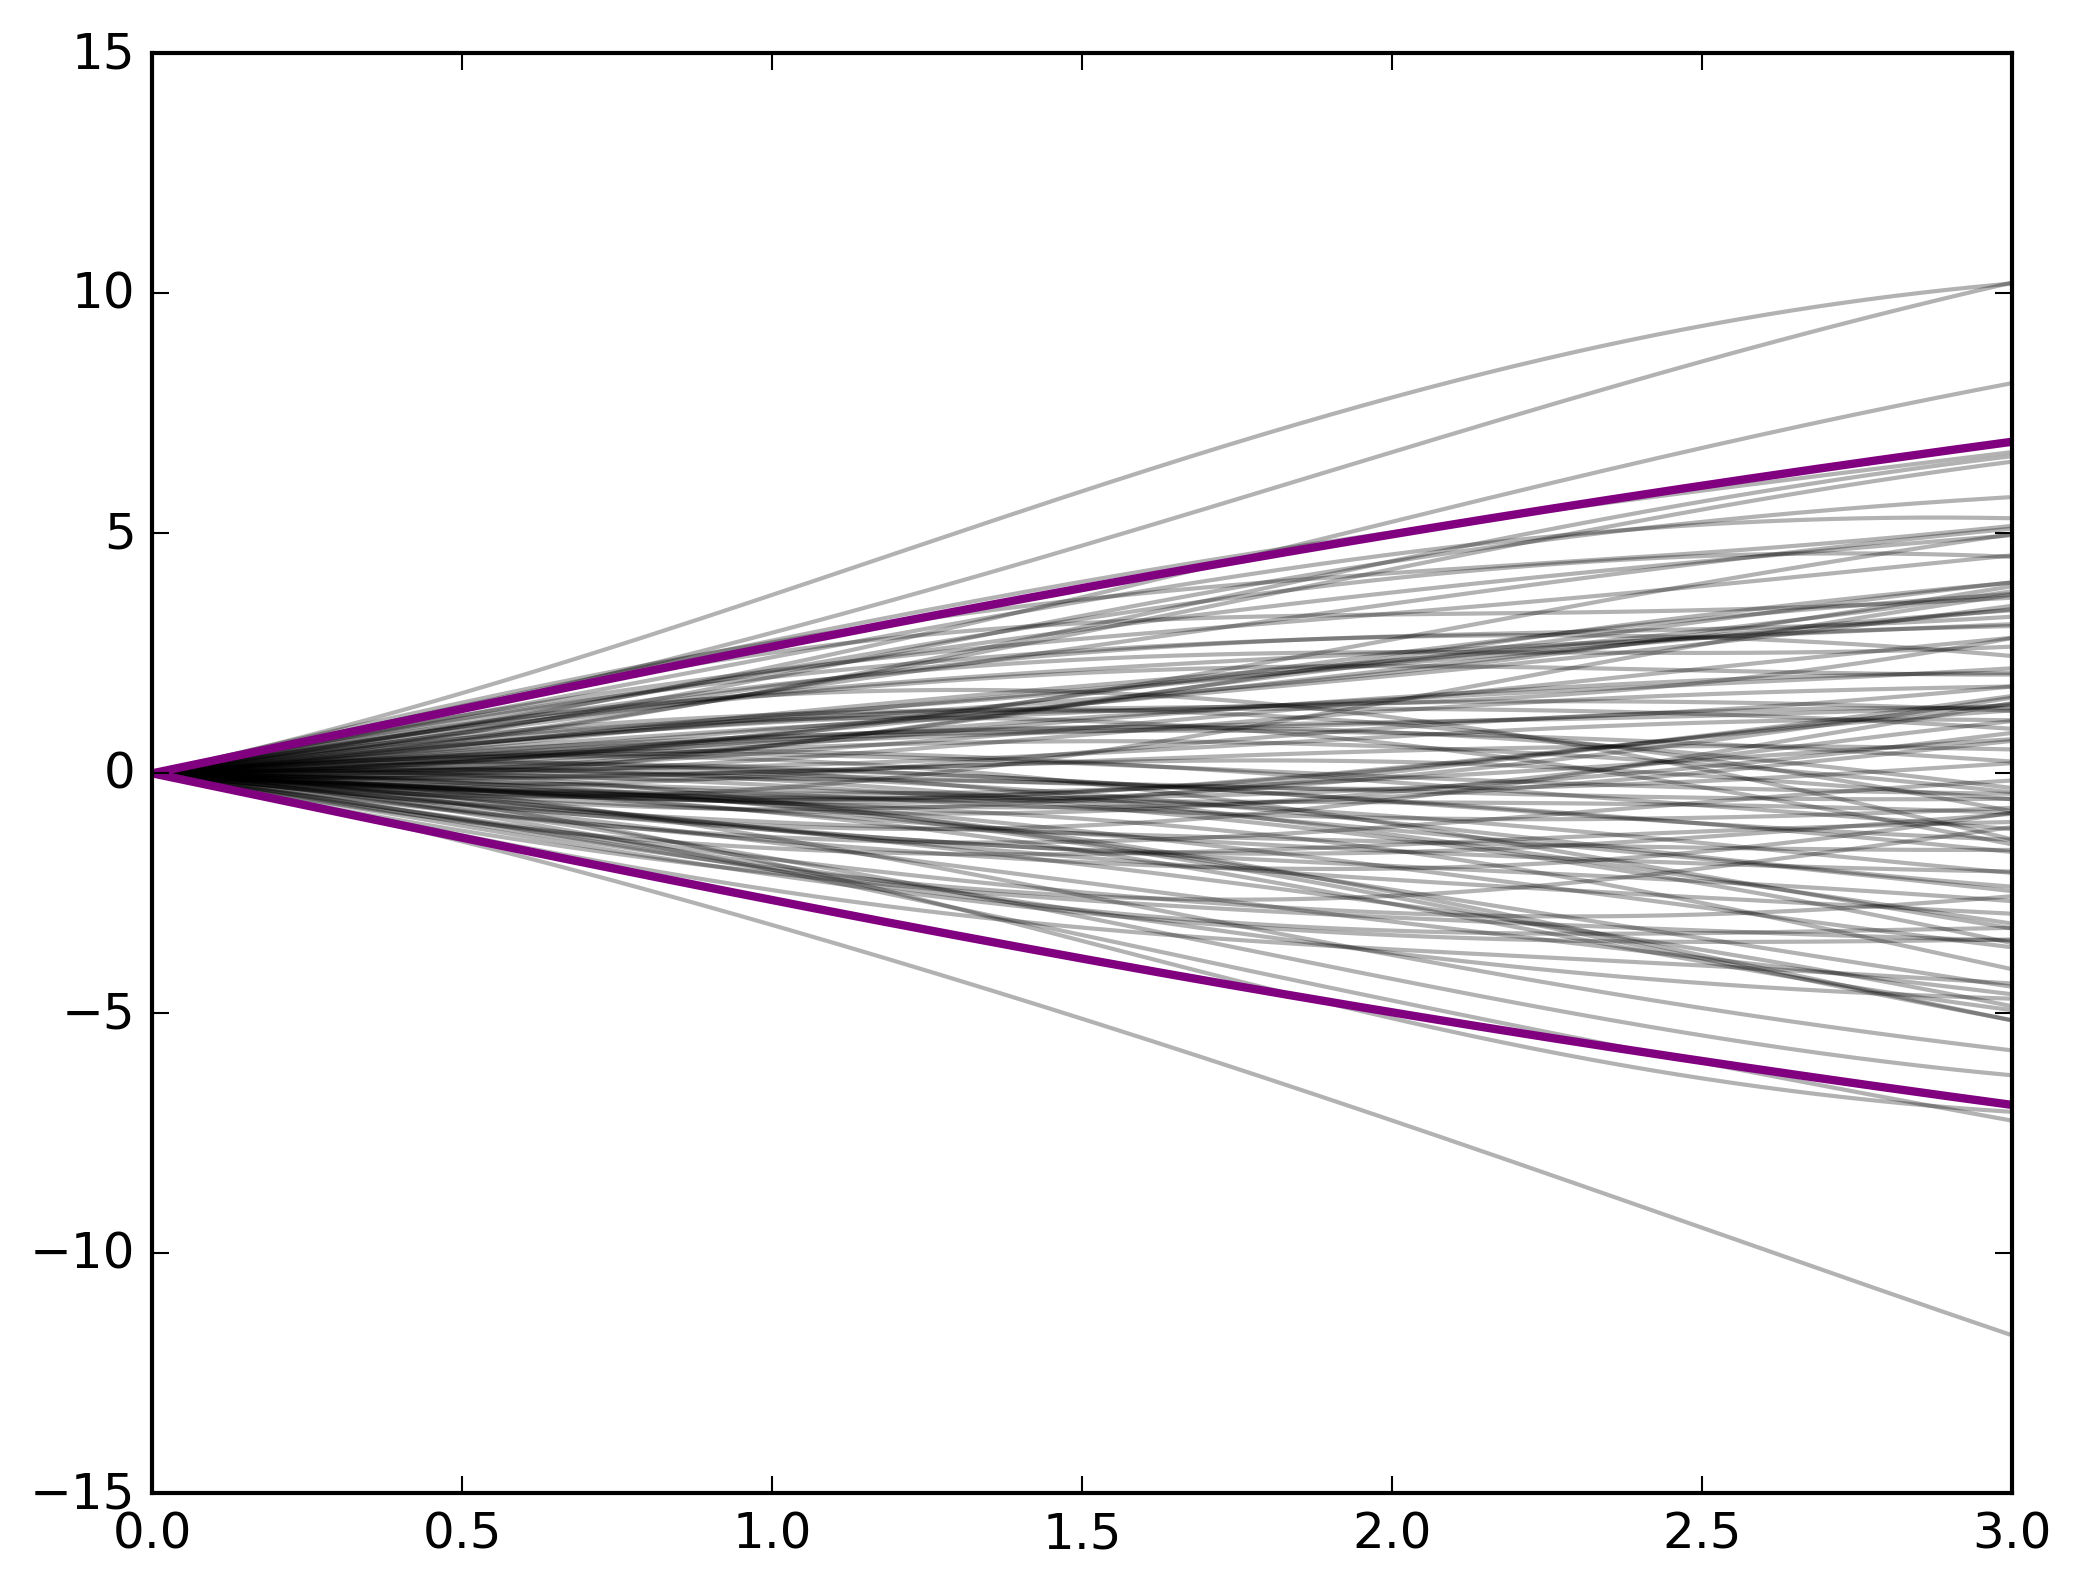

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324280b10>

In [10]:
xx = linspace(0,3,1000)
for _ in 1:100
    r=rand(prior_GP, xx, 1)
    dx=median(diff(xx))
    int_r = cumsum(r)*dx
    plt.plot(xx, int_r, color="black", alpha=0.3)
end
plt.plot(xx,  2*√(var_intgp.(xx, √se.σ2, √se.ℓ2)), linewidth=2, color="purple")
plt.plot(xx, -2*√(var_intgp.(xx, √se.σ2, √se.ℓ2)), linewidth=2, color="purple")

In [11]:
function var_intgp(x, σ, l)
    u = x / l / √2
    2 * σ^2 * l^2 * ( u * √π  * erf(u) + exp(-u^2) - 1.0)
end

var_intgp (generic function with 1 method)

In [12]:
import GaussianProcesses: cov, cov!, get_params, EmptyData, Kernel, MatF64
import GaussianProcesses: set_params!, num_params, dKij_dθp
type IntegSE <: Kernel
    ℓ2::Float64
    σ2::Float64
    IntegSE(ll::Float64, lσ::Float64) = new(exp(2*ll), exp(2*lσ))
end
IntegSE(se::SEIso) = IntegSE(get_params(se)...)

function cov(igse::IntegSE, x₁::Float64, x₂::Float64)
    u = x₁ / √(2 * igse.ℓ2)
    v = x₂ / √(2 * igse.ℓ2)
    uv = abs(u-v)
    ku = u * erf(u) + 1/√π * exp(-u^2)
    kv = v * erf(v) + 1/√π * exp(-v^2)
    kuv = uv * erf(uv) + 1/√π * exp(-uv^2)
    return igse.σ2 * igse.ℓ2 * √π * (ku + kv - kuv - 1/√π)
end
@inline function dk_dll(igse::IntegSE, x₁::Float64, x₂::Float64)
    u = x₁ / √(2 * igse.ℓ2)
    v = x₂ / √(2 * igse.ℓ2)
    uv = abs(u-v)
    dku = erf(u)
    dkv = erf(v)
    dkuv = erf(uv)
    
    ku = u * erf(u) + 1/√π * exp(-u^2)
    kv = v * erf(v) + 1/√π * exp(-v^2)
    kuv = uv * erf(uv) + 1/√π * exp(-uv^2)
    #dudll = -u
    dk_dll = igse.σ2 * igse.ℓ2 * √π * (-u*dku -v*dkv +uv*dkuv) +
             2 * cov(igse, x₁, x₂)
    return dk_dll
end

dk_dll (generic function with 1 method)

In [13]:
dk_dlσ(k::IntegSE, x₁::Float64, x₂::Float64) = 2.0*cov(k,x₁,x₂)

function cov(igse::IntegSE, x₁::AbstractVector{Float64}, x₂::AbstractVector{Float64})
    return cov(igse, x₁[1], x₂[1])
end
function cov!{M<:MatF64}(cK::MatF64, igse::IntegSE, X::M, data::EmptyData)
    dim,nobsv = size(X)
    @assert dim==1
    for i in 1:nobsv
        for j in 1:i
            cK[i,j] = cov(igse, X[1,i], X[1,j])
            cK[j,i] = cK[i,j]
        end
    end
end
function addcov!{M<:MatF64}(cK::MatF64, igse::IntegSE, X::M, data::EmptyData)
    dim,nobsv = size(X)
    @assert dim==1
    for i in 1:nobsv
        for j in 1:i
            cK[i,j] += cov(igse, X[1,i], X[1,j])
            cK[j,i] = cK[i,j]
        end
    end
end
function multcov!{M<:MatF64}(cK::MatF64, igse::IntegSE, X::M, data::EmptyData)
    dim,nobsv = size(X)
    @assert dim==1
    for i in 1:nobsv
        for j in 1:i
            cK[i,j] *= cov(igse, X[1,i], X[1,j])
            cK[j,i] = cK[i,j]
        end
    end
end
function cov{M<:MatF64}(igse::IntegSE, X::M, data::EmptyData)
    dim,nobsv = size(X)
    cK = Array(Float64, nobsv, nobsv)
    cov!(cK, igse, X, data)
    return cK
end

function cov!{M1<:MatF64,M2<:MatF64}(cK::MatF64, igse::IntegSE, X₁::M1, X₂::M2)
    @assert size(X₁,1)==size(X₂,1)==1
    nobsv1 = size(X₁, 2)
    nobsv2 = size(X₂, 2)
    for i in 1:nobsv1
        for j in 1:nobsv2
            cK[i,j] = cov(igse, X₁[1,i], X₂[1,j])
        end
    end
end  
function addcov!{M1<:MatF64,M2<:MatF64}(cK::MatF64, igse::IntegSE, X₁::M1, X₂::M2)
    @assert size(X₁,1)==size(X₂,1)==1
    nobsv1 = size(X₁, 2)
    nobsv2 = size(X₂, 2)
    for i in 1:nobsv1
        for j in 1:nobsv2
            cK[i,j] += cov(igse, X₁[1,i], X₂[1,j])
        end
    end
end  
function multcov!{M1<:MatF64,M2<:MatF64}(cK::MatF64, igse::IntegSE, X₁::M1, X₂::M2)
    @assert size(X₁,1)==size(X₂,1)==1
    nobsv1 = size(X₁, 2)
    nobsv2 = size(X₂, 2)
    for i in 1:nobsv1
        for j in 1:nobsv2
            cK[i,j] *= cov(igse, X₁[1,i], X₂[1,j])
        end
    end
end  
function cov{M1<:MatF64,M2<:MatF64}(igse::IntegSE, X₁::M1, X₂::M2)
    nobsv1 = size(X₁, 2)
    nobsv2 = size(X₂, 2)
    cK = Array(Float64, nobsv1, nobsv2)
    cov!(cK, igse, X₁, X₂)
    return cK
end

get_params(igse::IntegSE) = Float64[log(igse.ℓ2)/2.0, log(igse.σ2)/2.0]
get_param_names(::IntegSE) = [:ll, :lσ]
function set_params!(igse::IntegSE, hyp::Vector{Float64})
    length(hyp) == 2 || throw(ArgumentError("Squared exponential only has two parameters"))
    igse.ℓ2, igse.σ2 = exp(2.0*hyp)
end
num_params(igse::IntegSE) = 2

@inline function dKij_dθp{M<:MatF64}(igse::IntegSE, X::M, i::Int, j::Int, p::Int, dim::Int)
    if p==1
        return dk_dll(igse, X[1,i], X[1,j])
    elseif p==2
        return dk_dlσ(igse, X[1,i], X[1,j])
    else
        return NaN
    end
end
@inline function dKij_dθp{M<:MatF64}(igse::IntegSE, X::M, data::EmptyData, i::Int, j::Int, p::Int, dim::Int)
    return dKij_dθp(igse,X,i,j,p,dim)
end
kernel_data_key(::IntegSE, X::MatF64) = "EmptyData"


kernel_data_key (generic function with 1 method)

In [14]:
var_intgp(2.0, √se.σ2, √se.ℓ2)

6.19897408442219

In [15]:
cov(IntegSE(se), 2.0, 2.0)

6.1989740844221926

In [16]:
f(x) = cov(IntegSE(x, 0.2), 2.0, 3.0)
df(x) = dk_dll(IntegSE(x, 0.2), 2.0, 3.0)

df (generic function with 1 method)

In [17]:
f(0.3)
df(0.3)

3.061362212276796

In [18]:
using Calculus

In [19]:
Calculus.gradient(f, 0.3)

3.061362212334097

In [58]:
pstar = GP(;m=MeanZero(), )
n = 200
X = collect(linspace(0,20,n))'
Y_nonoise = vec(rand(prior_GP, X, 1))
Y = Y_nonoise + randn(n)
gp_fit = GP(X, Y, MeanZero(), IntegSE(0.0,0.0), 0.0)

GP object:
  Dim = 1
  Number of observations = 200
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: IntegSE, Params: [0.0,0.0]
  Input observations = 
[0.0 0.100503 … 19.8995 20.0]
  Output observations = [1.78998,2.0874,0.0487469,0.842035,1.96692,0.781112,0.339635,0.0183105,2.16536,1.46024  …  2.17629,-2.20424,2.11522,-1.02188,-0.105373,1.01241,-1.51921,-0.898103,-0.634388,1.80233]
  Variance of observation noise = 1.0
  Marginal Log-Likelihood = -307.859

In [51]:
GaussianProcesses.update_mll!(gp_fit)

-290.2435512983888

In [52]:
GaussianProcesses.update_mll_and_dmll!(gp_fit)

In [53]:
predict(gp_fit, linspace(0.5,10.5,10)', full_cov=true)

([-0.260732,-0.83327,-0.243141,0.831948,0.21692,-1.3487,-1.64293,-0.734938,0.459818,1.01678],PDMats.PDMat{Float64,Array{Float64,2}}(10,[0.0346379 0.0218883 … -4.78861e-6 1.54621e-6; 0.0218883 0.0621532 … -5.25901e-7 -3.92843e-6; … ; -4.78861e-6 -5.25901e-7 … 0.0615988 0.0197023; 1.54621e-6 -3.92843e-6 … 0.0197023 0.0615988],Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.186113 0.117608 … -2.57296e-5 8.30791e-6; 0.0 0.219822 … 1.13733e-5 -2.23158e-5; … ; 0.0 0.0 … 0.225531 0.0998147; 0.0 0.0 … 0.0 0.225533]))

In [54]:
optimize!(gp_fit)

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0,0.0,0.0]
 * Minimizer: [-0.09278486165149383,-0.1349166031401432, ...]
 * Minimum: 2.880498e+02
 * Iterations: 25
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 94
 * Gradient Calls: 69

In [55]:
prior_GP.k.σ2, prior_GP.k.ℓ2

(1.188964898227381,1.7307959450822066)

In [56]:
gp_fit.k.σ2, gp_fit.k.ℓ2, gp_fit.logNoise

(0.8748811533340659,0.2764486440503569,-0.09278486165149383)

# Extrapolating behavior

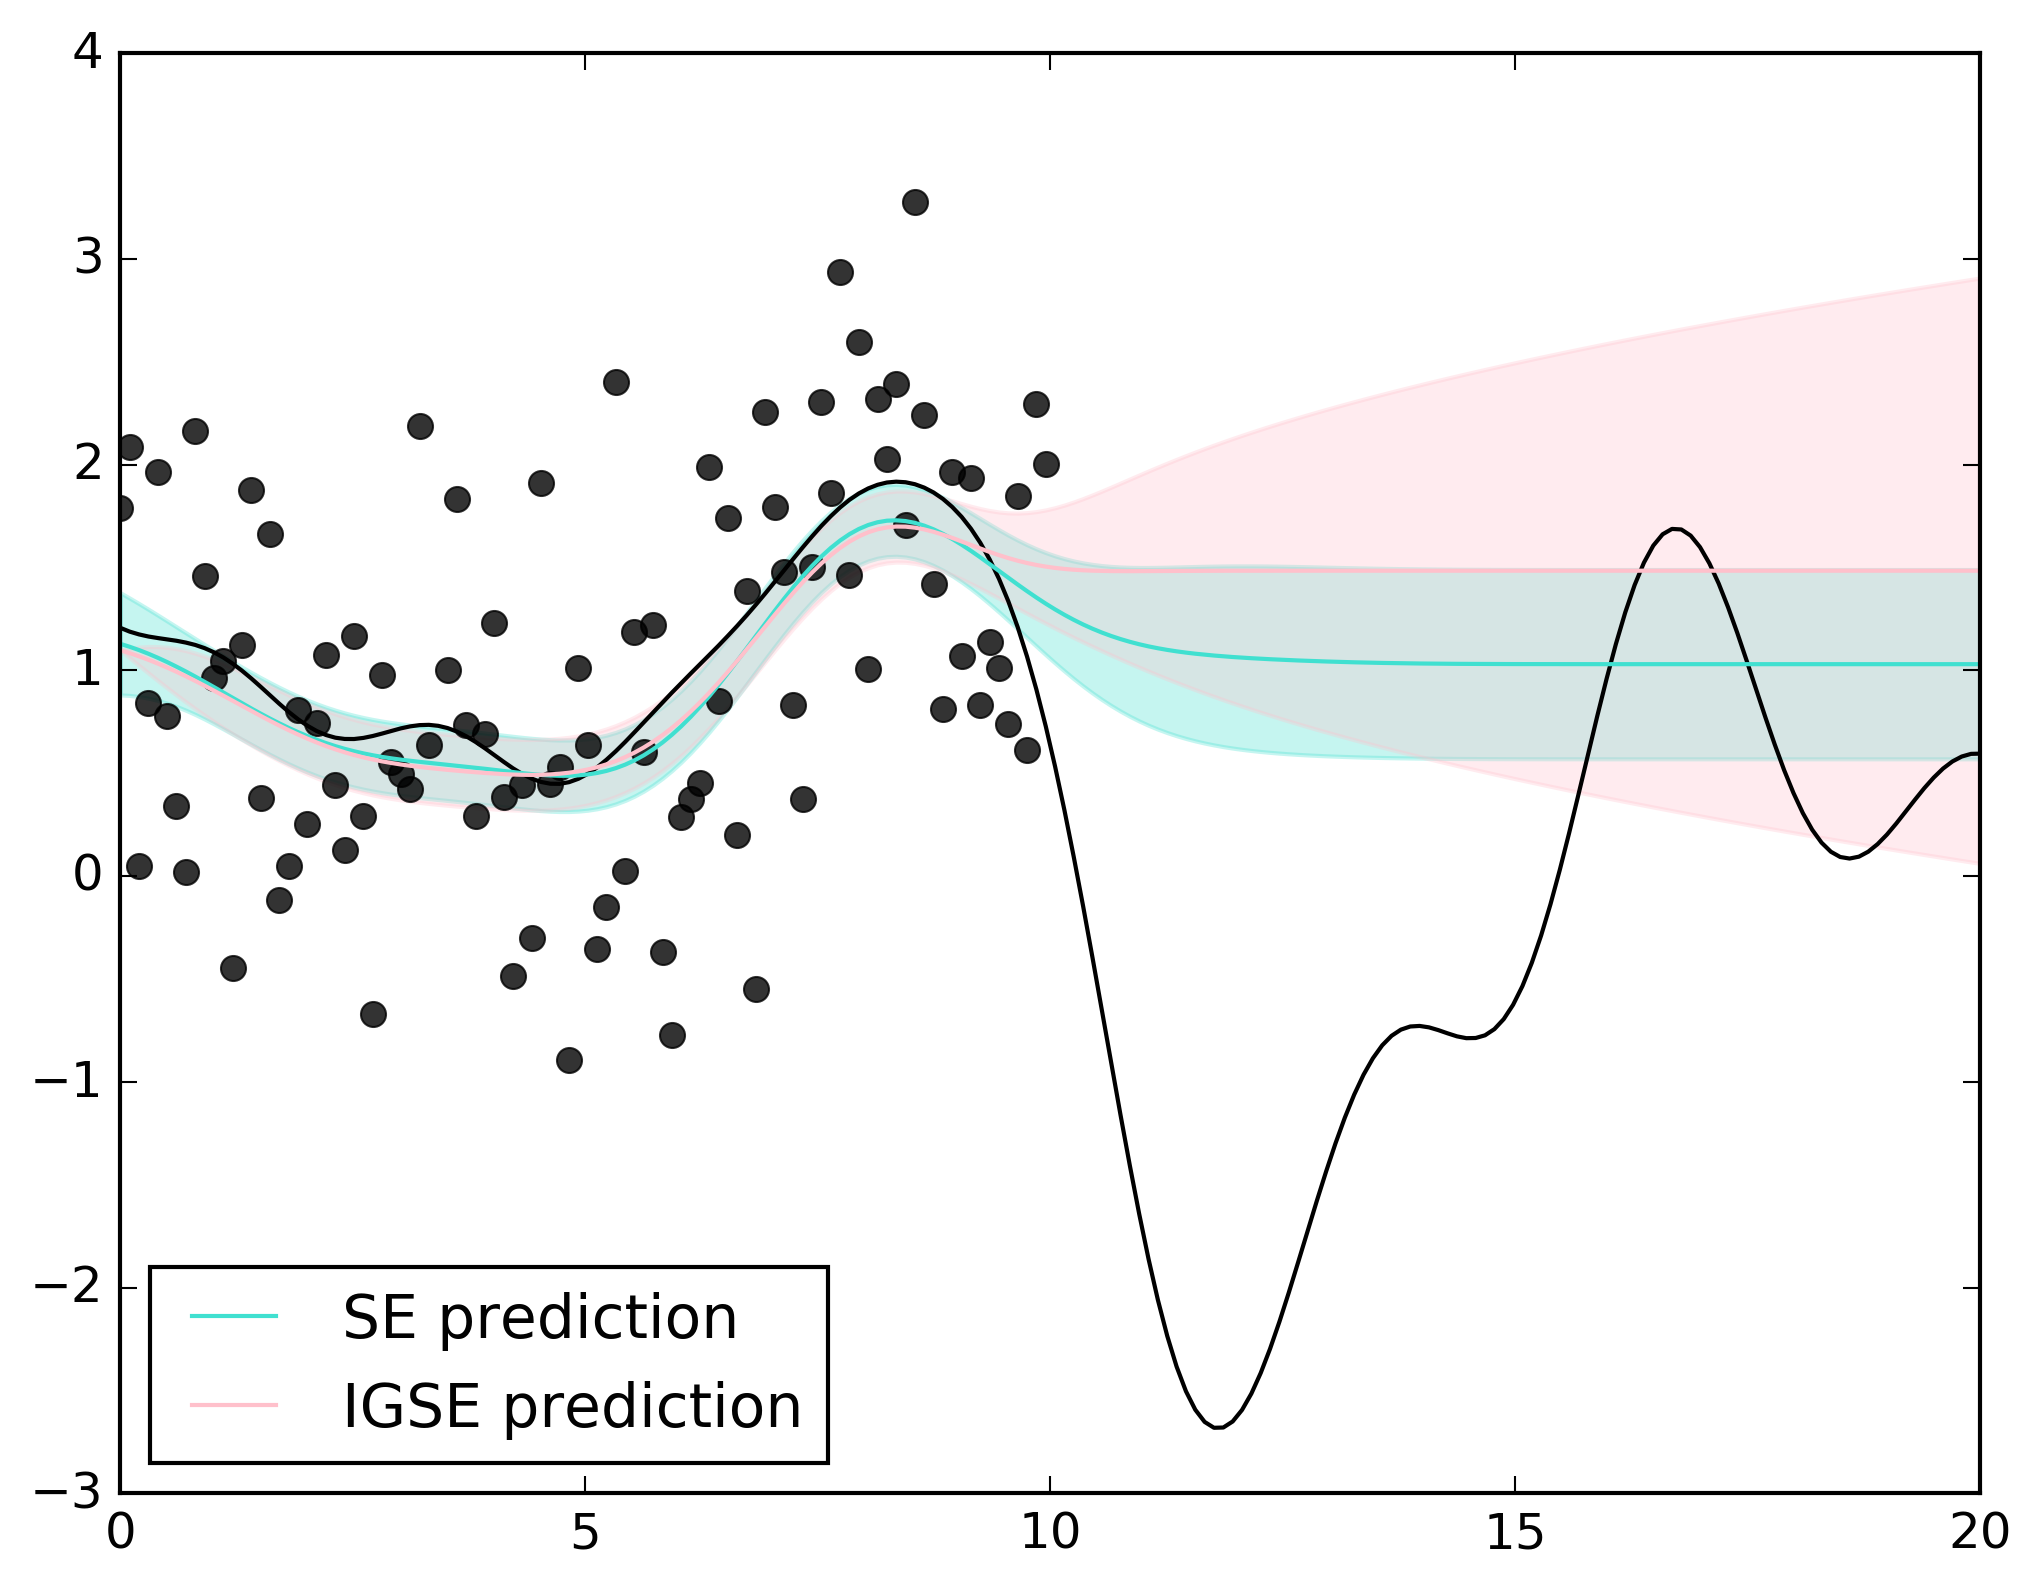

PyObject <matplotlib.legend.Legend object at 0x31d07f350>

In [66]:
se = SEIso(0.0, 0.0)
igse = IntegSE(se)
train = vec(X) .< 10
plt.plot(vec(X[:,train]), Y[train], "o", color="black", alpha=0.8)
plt.plot(vec(X), Y_nonoise, "-", color="black")
se_fit   = GP(X[:,train], Y[train], MeanZero(), se, -1.0)
GaussianProcesses.update_mll_and_dmll!(se_fit)
optimize!(se_fit)
igse_fit = GP(X[:,train], Y[train], MeanZero(), igse, -1.0)
GaussianProcesses.update_mll_and_dmll!(igse_fit)
optimize!(igse_fit)
se_pred = predict(se_fit, X; full_cov=true)
igse_pred = predict(igse_fit, X; full_cov=true)
plt.plot(vec(X), se_pred[1], label="SE prediction", color="turquoise")
plt.fill_between(vec(X), se_pred[1]-√diag(se_pred[2]), se_pred[1]+√diag(se_pred[2]), color="turquoise", alpha=0.3)
plt.plot(vec(X), igse_pred[1], label="IGSE prediction", color="pink")
plt.fill_between(vec(X), igse_pred[1]-√diag(igse_pred[2]), igse_pred[1]+√diag(igse_pred[2]), color="pink", alpha=0.3)
plt.legend(loc="lower left")

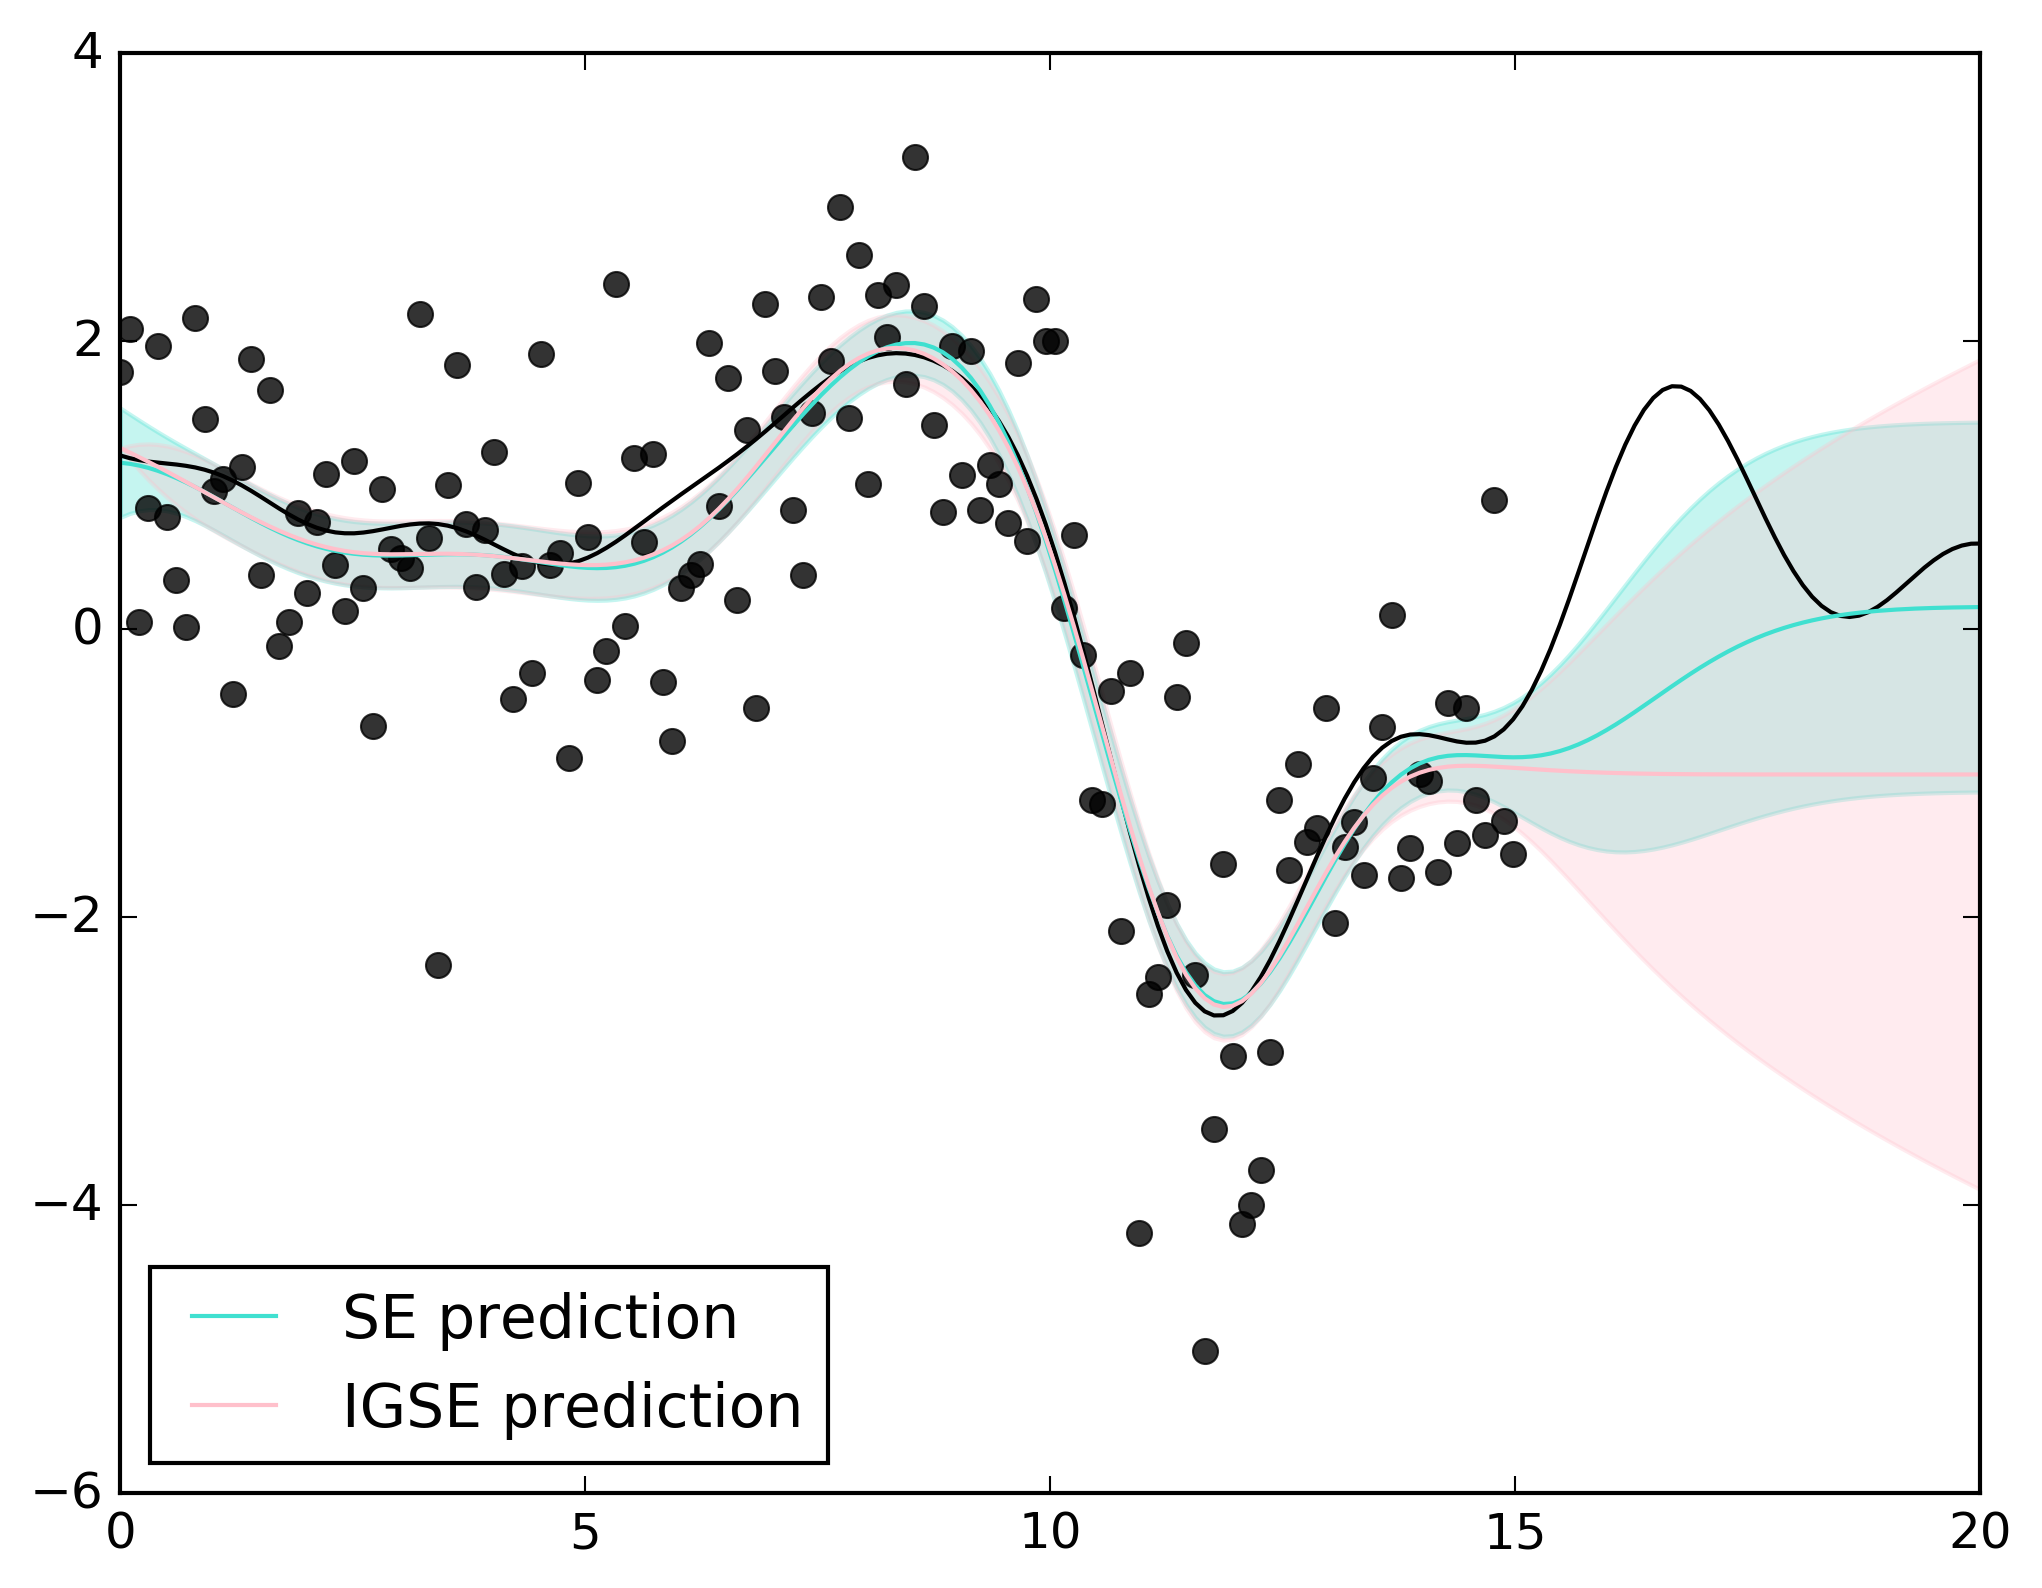

PyObject <matplotlib.legend.Legend object at 0x32ee73790>

In [67]:
se = SEIso(0.0, 0.0)
igse = IntegSE(se)
train = vec(X) .< 15
plt.plot(vec(X[:,train]), Y[train], "o", color="black", alpha=0.8)
plt.plot(vec(X), Y_nonoise, "-", color="black")
se_fit   = GP(X[:,train], Y[train], MeanZero(), se, -1.0)
GaussianProcesses.update_mll_and_dmll!(se_fit)
optimize!(se_fit)
igse_fit = GP(X[:,train], Y[train], MeanZero(), igse, -1.0)
GaussianProcesses.update_mll_and_dmll!(igse_fit)
optimize!(igse_fit)
se_pred = predict(se_fit, X; full_cov=true)
igse_pred = predict(igse_fit, X; full_cov=true)
plt.plot(vec(X), se_pred[1], label="SE prediction", color="turquoise")
plt.fill_between(vec(X), se_pred[1]-√diag(se_pred[2]), se_pred[1]+√diag(se_pred[2]), color="turquoise", alpha=0.3)
plt.plot(vec(X), igse_pred[1], label="IGSE prediction", color="pink")
plt.fill_between(vec(X), igse_pred[1]-√diag(igse_pred[2]), igse_pred[1]+√diag(igse_pred[2]), color="pink", alpha=0.3)
plt.legend(loc="lower left")

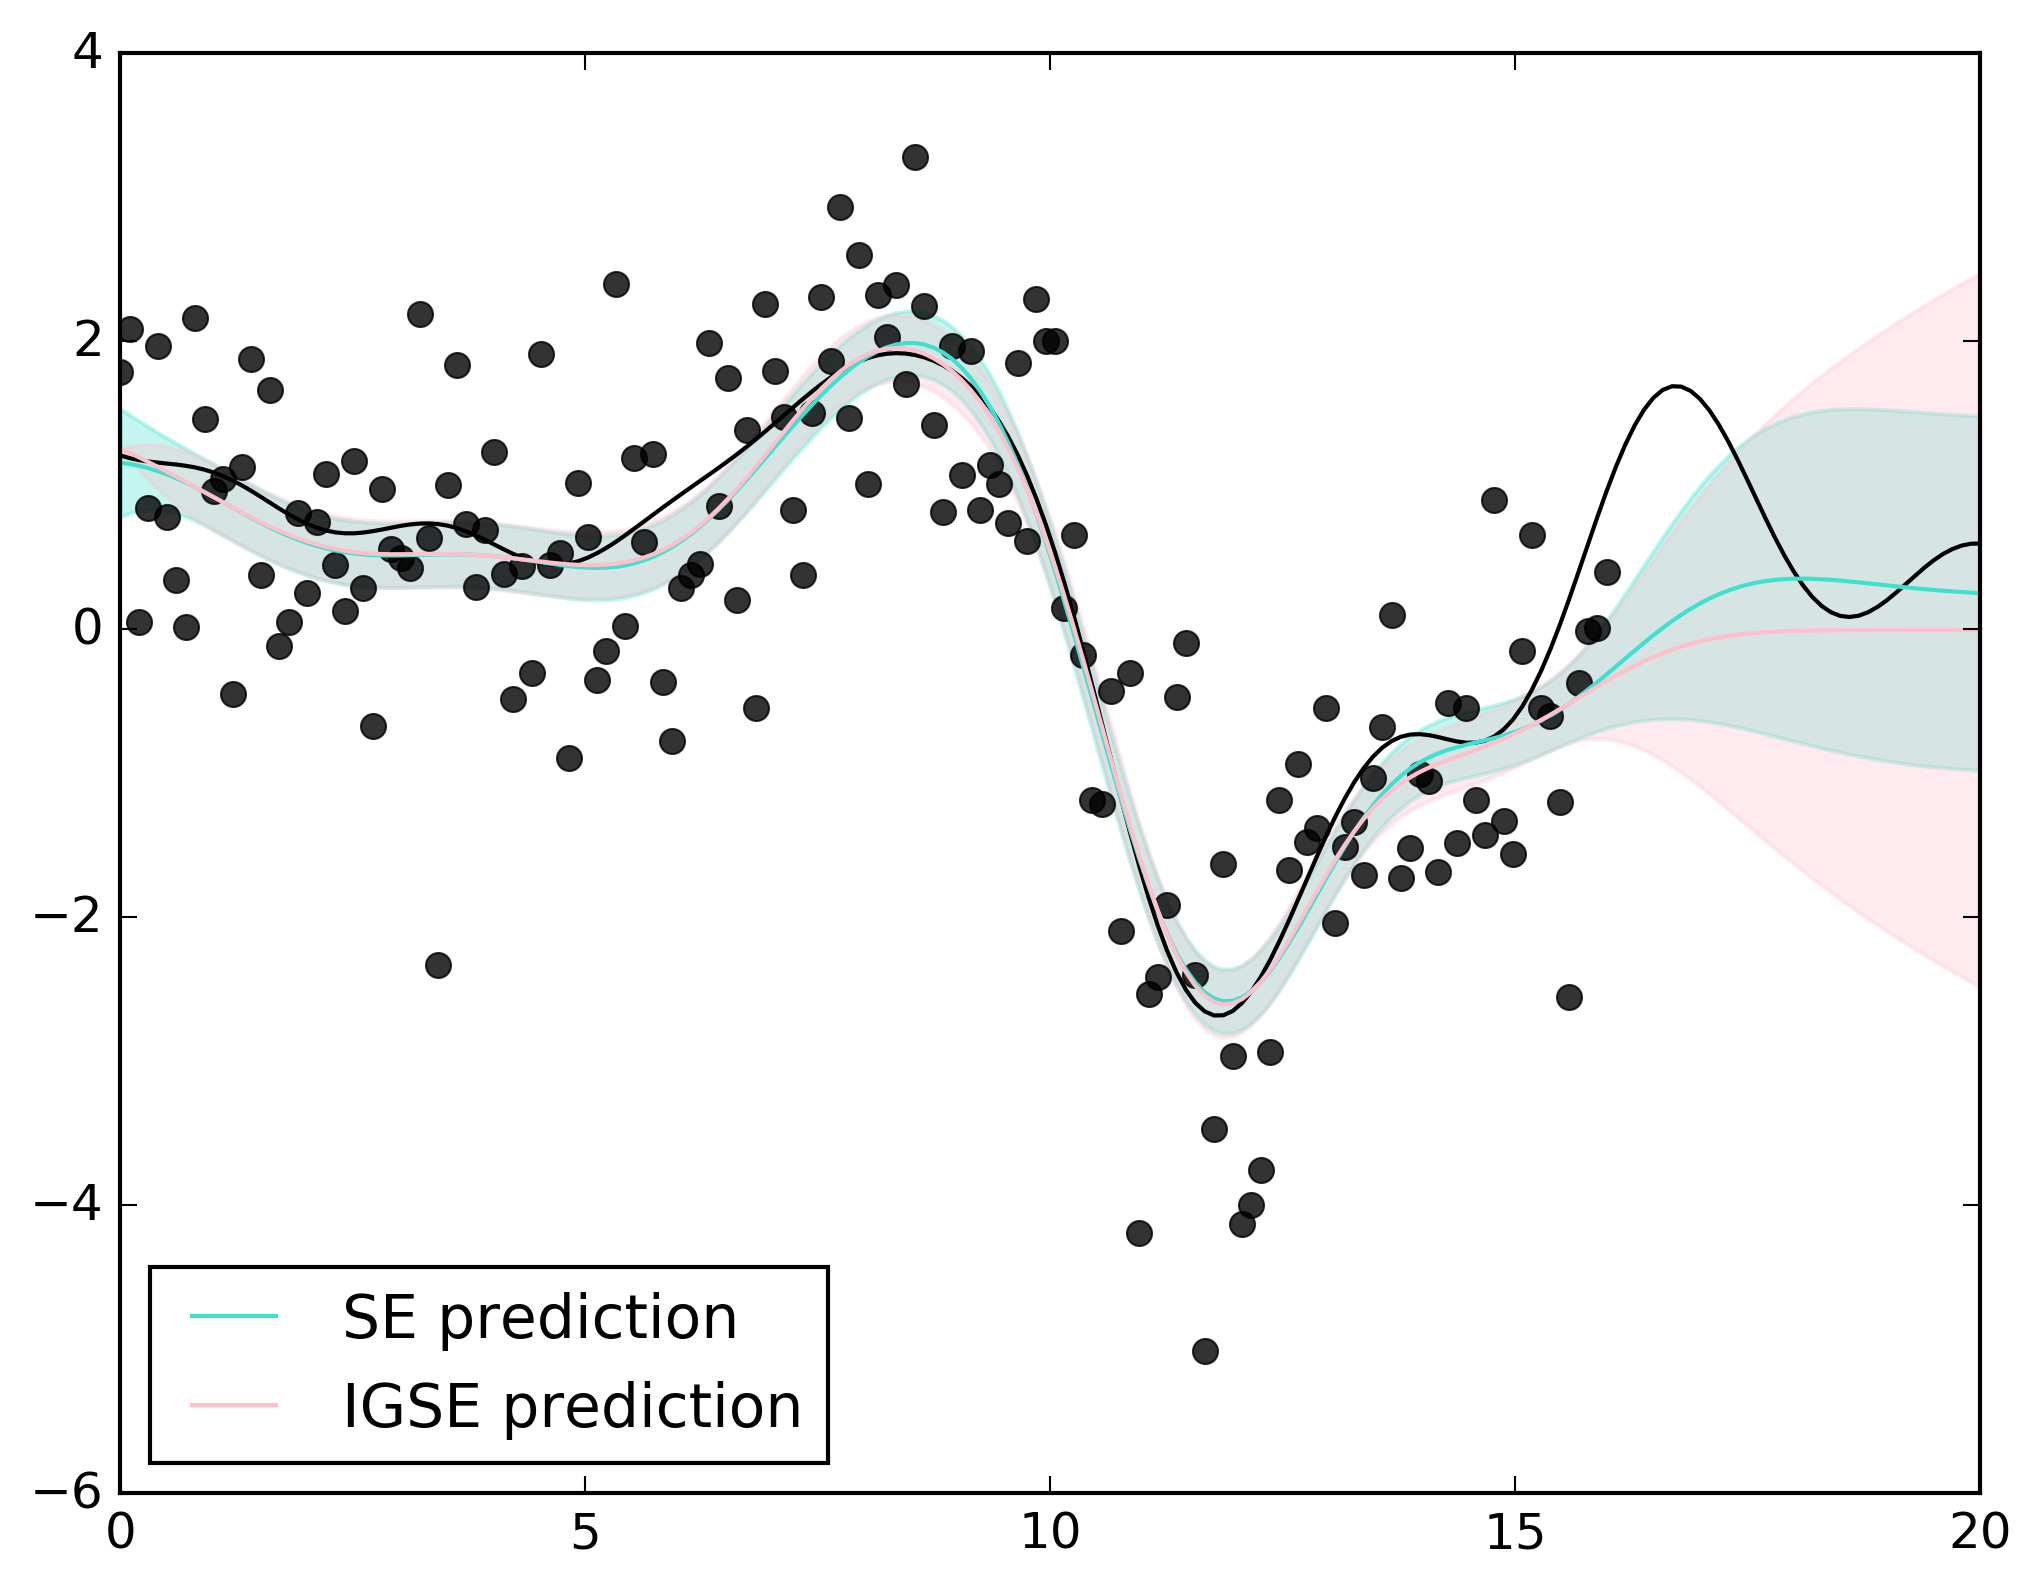

PyObject <matplotlib.legend.Legend object at 0x32de91c10>

In [68]:
se = SEIso(0.0, 0.0)
igse = IntegSE(se)
train = vec(X) .< 16
plt.plot(vec(X[:,train]), Y[train], "o", color="black", alpha=0.8)
plt.plot(vec(X), Y_nonoise, "-", color="black")
se_fit   = GP(X[:,train], Y[train], MeanZero(), se, -1.0)
GaussianProcesses.update_mll_and_dmll!(se_fit)
optimize!(se_fit)
igse_fit = GP(X[:,train], Y[train], MeanZero(), igse, -1.0)
GaussianProcesses.update_mll_and_dmll!(igse_fit)
optimize!(igse_fit)
se_pred = predict(se_fit, X; full_cov=true)
igse_pred = predict(igse_fit, X; full_cov=true)
plt.plot(vec(X), se_pred[1], label="SE prediction", color="turquoise")
plt.fill_between(vec(X), se_pred[1]-√diag(se_pred[2]), se_pred[1]+√diag(se_pred[2]), color="turquoise", alpha=0.3)
plt.plot(vec(X), igse_pred[1], label="IGSE prediction", color="pink")
plt.fill_between(vec(X), igse_pred[1]-√diag(igse_pred[2]), igse_pred[1]+√diag(igse_pred[2]), color="pink", alpha=0.3)
plt.legend(loc="lower left")